# MSAI Computer Vision
## Seminar 02

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import transforms

## Pytorch CNN implementation

Today we're gonna use modern CNN architecture features to create our own models and train them from scratch.

In [2]:
import math
import time
import warnings
from collections import defaultdict
from random import choice

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# 1. Loading CIFAR10 Dataset

Let's use CIFAR10 dataset for our CNN model development as a small and simple toy dataset.
It is easy to download it using torchvision.datasets.

In [3]:
from torchvision import datasets


train_ds = datasets.CIFAR10("./cifar10", train=True, download=True)
val_ds = datasets.CIFAR10("./cifar10", train=False, download=True)

print(f"Train / val size: {len(train_ds)} / {len(val_ds)}")

Files already downloaded and verified
Files already downloaded and verified
Train / val size: 50000 / 10000


In [4]:
np.array(train_ds[0][0]).max()

255

let's see what classes/labels we have and make sure that we have the same classes in train/val parts

In [5]:
num_classes = len(train_ds.classes)
print(f"num_classes: {num_classes}")

print("Training classes: ", train_ds.classes)
print("Validation classes: ", val_ds.classes)

num_classes: 10
Training classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Validation classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's plot some images from the dataset too:

In [6]:
def sample_from_dataset(dataset):
    class_names = dataset.classes
    num_classes = len(class_names)
    label_to_idx = defaultdict(list)

    for i, sample in enumerate(dataset):
        data, lbl = sample
        label_to_idx[lbl].append(i)

    grid_size = (2, int(num_classes / 2 + 0.5))
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 4)
    for lbl in range(num_classes):
        img, _ = dataset[choice(label_to_idx[lbl])]
        sample_title = "%s (label=%d)" % (class_names[lbl], lbl)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].imshow(img)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].set_title(sample_title)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].axis("off")
    return

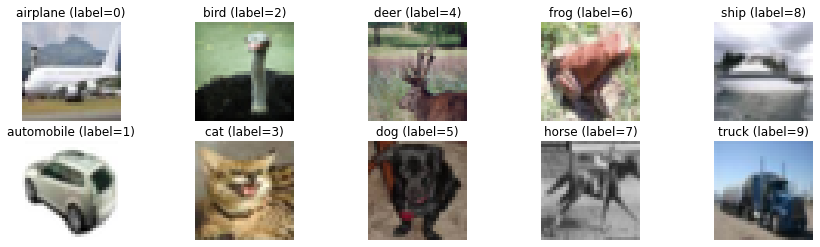

In [7]:
sample_from_dataset(train_ds)

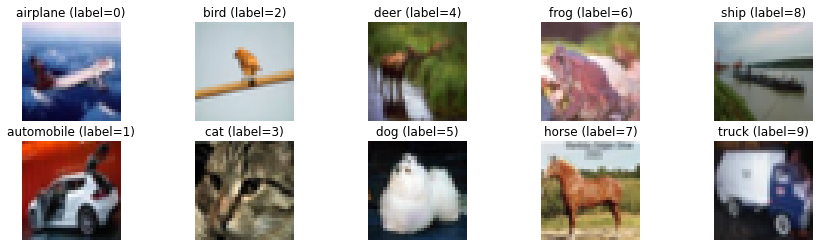

In [8]:
sample_from_dataset(val_ds)

We see that image classes are correct for both training and validation dataset parts, so we can use this dataset in our experiments.


# 2. Data Augmentation and Data Loaders

Here we use all seminars transformations and add rotation and random grayscale

Such pre-processing shall include:
* converting image np.ndarrays / PIL images to torch tensors
* scaling image pixel values from [0;255] to [0;1]
* (optionally) normalizing data by subtracting some mean value and dividing by some std value.

Such pre-processing is done using torchvision.transforms module.
The same module implements different random image perturbations, that can be used for image augmentation during CNN training.

**Question:** name at least 5 image augmentation, that we can apply to image classification task here?

In [9]:
# let's use ImageNet mean and std values for image pixel values
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

In [10]:
from torchvision import datasets, transforms


base_transforms = [transforms.ToTensor(), transforms.Normalize(means, stds)]
augmented_transforms = [
    # add your own augmentations here
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(hue=0.01, brightness=0.3, contrast=0.3, saturation=0.3),
]
augmented_transforms += base_transforms

transform_basic = transforms.Compose(base_transforms)
transform_augment = transforms.Compose(augmented_transforms)

In [11]:
train_ds = datasets.CIFAR10("./cifar10", train=True, download=True, transform=transform_augment)
val_ds = datasets.CIFAR10("./cifar10", train=False, download=True, transform=transform_basic)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
batch_size = 256
train_batch_gen = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [13]:
img_batch, label_batch = next(iter(train_batch_gen))
print(f"Label tensor size: {label_batch.size()}")
print(f"Batch tensor size [B, C, H, W] = {img_batch.size()}")
print(f"Batch tensor range: min = {img_batch.min().item():.4f} max = {img_batch.max().item():.4f} ")

Label tensor size: torch.Size([256])
Batch tensor size [B, C, H, W] = torch.Size([256, 3, 32, 32])
Batch tensor range: min = -2.4291 max = 2.7537 


In [14]:
def sample_from_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(stds * batch_image_ndarray + means, 0, 1)

        # display batch samples with labels
        sample_title = "%s (%d)" % (class_names[label_batch[i]], label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    return

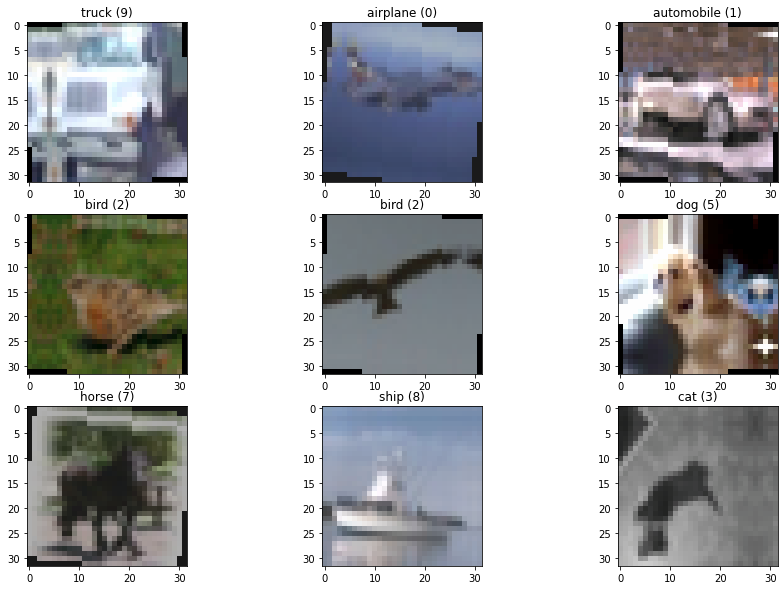

In [15]:
sample_from_generator(train_batch_gen)

In [16]:
num_classes = len(train_ds.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


## 3. Implementing More Layers

Let's see how one can implement some state-of-the-art layers, such as residual blocks, densenet dense and transition blocks, etc.
This migh help you when building your CNN model from scratch.

### 3.1 ResNet Implementation

In [17]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.relu2 = nn.LeakyReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu2(out)

        return out

In [18]:
class BaseResNet(nn.Module):
    def __init__(self, block, layers, num_classes, norm_layer=None):
        super(BaseResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.layer1 = self._make_layer(block, self.inplanes, layers[0])
        self.layer2 = self._make_layer(block, self.inplanes * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, self.inplanes * 4, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(self.inplanes, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

### 3.2 DenseNet Implementation

As you remember from the lecture, we need to implement Dense block, which in this notation is called ``Basic``:\

<img src="dense_concat.gif">

In [19]:
class DenseBlock(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(out)))
        out = torch.cat([out, x], 1)
        return out

Another option for Dense block is using ``Bottleneck`` approach, which expands channel number before main convolution operation to increases data dimensionality and simplify class feature separation for convolution.

<img src="dense_bottleneck.png">,

## We change bottleneck, add here excitation residual layer

In [20]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4 * growth_rate, kernel_size=1, bias=False)
        self.relu1 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu2 = nn.LeakyReLU()
        self.se_res = SEResidual(growth_rate, growth_rate)   # I added

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(x)))
        out = self.conv2(self.bn2(self.relu2(out)))
        out = self.se_res(out)            # I added
        out = torch.cat([out, x], 1)
        return out

Another important part of DenseNet model is the ``Transition`` block, which allows to decrease data dimensionality in between different Dense blocks:

In [21]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv(self.bn(self.relu(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [22]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3] * growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = self.gap(F.relu(self.bn(out)))
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

### 3.3 Squeeze & Excitation Blocks

In [23]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SEResidual(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(SEResidual, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.se_layer = SELayer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_layer(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

# 4. Task
Your task is to combine the aforementioned approaches and reach the performance baseline of at least **91%** validation set accuracy.
You may use any augmentations and architecture tricks that you consider necessary.

You can't use ImageNet-pretrained models from **torchvision** library for fine-tuning on CIFAR10.

Task solution should consist of two parts:
- model checkpoint with the highest validation accuracy you could achieve
- a script **run_checkpoint.py**, which loads the checkpoint state dict to model class, loads CIFAR10 dataset and runs checkpoint validation on this dataset 

In [24]:
model = DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=12, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/home/rkorkin/anaconda3/envs/DL/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [25]:
from typing import Dict

from catalyst.core.logger import ILogger

# it is merely a helper util for cleaner output
from catalyst.loggers.console import ConsoleLogger


def my_format_metrics(dct: Dict):
    return " | ".join([f"{k}: {float(dct[k]):.3f}" for k in sorted(dct.keys())])


class CustomLogger(ConsoleLogger):
    def log_metrics(
        self,
        metrics: Dict[str, float],
        scope: str = None,
        # experiment info
        run_key: str = None,
        global_epoch_step: int = 0,
        global_batch_step: int = 0,
        global_sample_step: int = 0,
        # stage info
        stage_key: str = None,
        stage_epoch_len: int = 0,
        stage_epoch_step: int = 0,
        stage_batch_step: int = 0,
        stage_sample_step: int = 0,
        # loader info
        loader_key: str = None,
        loader_batch_len: int = 0,
        loader_sample_len: int = 0,
        loader_batch_step: int = 0,
        loader_sample_step: int = 0,
    ) -> None:
        """Logs loader and epoch metrics to stdout."""
        if scope == "loader" and self._log_loader_metrics:
            prefix = f"{loader_key} ({stage_epoch_step}/{stage_epoch_len}) "
            msg = prefix + my_format_metrics(metrics)
            print(msg)
        elif scope == "epoch" and self._log_epoch_metrics:
            prefix = f"* Epoch ({stage_epoch_step}/{stage_epoch_len}) "
            msg = prefix + my_format_metrics(metrics["_epoch_"])
            print(msg)

from catalyst import dl, utils


runner = dl.SupervisedRunner(
    input_key="img", output_key="logits", target_key="targets", loss_key="loss"
)

loaders = {"train": train_batch_gen, "valid": val_batch_gen}

In [26]:
from sklearn.metrics import accuracy_score


def load_ckpt(path, model, device=torch.device("cpu")):
    """
    Load saved checkpoint weights to model
    :param path: full path to checkpoint
    :param model: initialized model class nested from nn.Module()
    :param device: base torch device for validation
    :return: model with loaded 'state_dict'
    """
    ckpt = torch.load(path, map_location=device)
    ckpt_dict = ckpt["model_state_dict"]
    model_dict = model.state_dict()
    ckpt_dict = {k: v for k, v in ckpt_dict.items() if k in model_dict}
    model_dict.update(ckpt_dict)
    model.load_state_dict(model_dict)
    return model


@torch.no_grad()
def validate_model(model, loader, device):
    """
    Evaluate implemented model
    :param model: initialized model class nested from nn.Module() with loaded state dict
    :param loader batch data loader for evaluation set
    :param device: base torch device for validation
    :return: dict performance metrics
    """
    label_list = []
    pred_list = []
    model = model.to(device)
    for data_tensor, lbl_tensor in loader:
        lbl_values = lbl_tensor.cpu().view(-1).tolist()
        label_list.extend(lbl_values)
        logits = model(data_tensor.to(device))
        scores = F.softmax(logits.detach().cpu(), 1).numpy()
        pred_labels = np.argmax(scores, 1)
        pred_list.extend(pred_labels.ravel().tolist())

    labels = np.array(label_list)
    predicted = np.array(pred_list)
    acc = accuracy_score(labels, predicted)
    print(f"model accuracy: {acc:.4f}")
    metric_dict = {"accuracy": acc}
    return metric_dict

# increase epochs number to 50

In [27]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    loggers={"console": CustomLogger()},
    num_epochs=50,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
    ],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)

1/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (1/50) accuracy01: 0.431 | accuracy01/std: 0.101 | accuracy03: 0.759 | accuracy03/std: 0.092 | accuracy05: 0.892 | accuracy05/std: 0.063 | loss: 1.549 | loss/mean: 1.549 | loss/std: 0.240 | lr: 0.001 | momentum: 0.900


1/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (1/50) accuracy01: 0.571 | accuracy01/std: 0.032 | accuracy03: 0.867 | accuracy03/std: 0.020 | accuracy05: 0.957 | accuracy05/std: 0.010 | loss: 1.176 | loss/mean: 1.176 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (1/50) 


2/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (2/50) accuracy01: 0.624 | accuracy01/std: 0.049 | accuracy03: 0.887 | accuracy03/std: 0.028 | accuracy05: 0.960 | accuracy05/std: 0.015 | loss: 1.051 | loss/mean: 1.051 | loss/std: 0.117 | lr: 0.001 | momentum: 0.900


2/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (2/50) accuracy01: 0.689 | accuracy01/std: 0.027 | accuracy03: 0.923 | accuracy03/std: 0.016 | accuracy05: 0.978 | accuracy05/std: 0.008 | loss: 0.873 | loss/mean: 0.873 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900
* Epoch (2/50) 


3/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (3/50) accuracy01: 0.709 | accuracy01/std: 0.033 | accuracy03: 0.924 | accuracy03/std: 0.018 | accuracy05: 0.977 | accuracy05/std: 0.009 | loss: 0.830 | loss/mean: 0.830 | loss/std: 0.079 | lr: 0.001 | momentum: 0.900


3/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (3/50) accuracy01: 0.779 | accuracy01/std: 0.026 | accuracy03: 0.952 | accuracy03/std: 0.013 | accuracy05: 0.988 | accuracy05/std: 0.007 | loss: 0.633 | loss/mean: 0.633 | loss/std: 0.060 | lr: 0.001 | momentum: 0.900
* Epoch (3/50) 


4/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (4/50) accuracy01: 0.757 | accuracy01/std: 0.027 | accuracy03: 0.944 | accuracy03/std: 0.015 | accuracy05: 0.984 | accuracy05/std: 0.008 | loss: 0.694 | loss/mean: 0.694 | loss/std: 0.069 | lr: 0.001 | momentum: 0.900


4/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (4/50) accuracy01: 0.794 | accuracy01/std: 0.026 | accuracy03: 0.959 | accuracy03/std: 0.014 | accuracy05: 0.991 | accuracy05/std: 0.006 | loss: 0.592 | loss/mean: 0.592 | loss/std: 0.066 | lr: 0.001 | momentum: 0.900
* Epoch (4/50) 


5/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (5/50) accuracy01: 0.786 | accuracy01/std: 0.027 | accuracy03: 0.953 | accuracy03/std: 0.013 | accuracy05: 0.988 | accuracy05/std: 0.006 | loss: 0.618 | loss/mean: 0.618 | loss/std: 0.061 | lr: 0.001 | momentum: 0.900


5/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (5/50) accuracy01: 0.823 | accuracy01/std: 0.022 | accuracy03: 0.967 | accuracy03/std: 0.009 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.518 | loss/mean: 0.518 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900
* Epoch (5/50) 


6/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (6/50) accuracy01: 0.805 | accuracy01/std: 0.025 | accuracy03: 0.958 | accuracy03/std: 0.013 | accuracy05: 0.989 | accuracy05/std: 0.006 | loss: 0.568 | loss/mean: 0.568 | loss/std: 0.067 | lr: 0.001 | momentum: 0.900


6/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (6/50) accuracy01: 0.832 | accuracy01/std: 0.021 | accuracy03: 0.968 | accuracy03/std: 0.011 | accuracy05: 0.992 | accuracy05/std: 0.005 | loss: 0.491 | loss/mean: 0.491 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900
* Epoch (6/50) 


7/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (7/50) accuracy01: 0.819 | accuracy01/std: 0.023 | accuracy03: 0.966 | accuracy03/std: 0.012 | accuracy05: 0.991 | accuracy05/std: 0.006 | loss: 0.516 | loss/mean: 0.516 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900


7/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (7/50) accuracy01: 0.843 | accuracy01/std: 0.024 | accuracy03: 0.974 | accuracy03/std: 0.009 | accuracy05: 0.994 | accuracy05/std: 0.004 | loss: 0.450 | loss/mean: 0.450 | loss/std: 0.063 | lr: 0.001 | momentum: 0.900
* Epoch (7/50) 


8/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (8/50) accuracy01: 0.833 | accuracy01/std: 0.021 | accuracy03: 0.969 | accuracy03/std: 0.011 | accuracy05: 0.992 | accuracy05/std: 0.005 | loss: 0.481 | loss/mean: 0.481 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900


8/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (8/50) accuracy01: 0.849 | accuracy01/std: 0.019 | accuracy03: 0.977 | accuracy03/std: 0.010 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.431 | loss/mean: 0.431 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900
* Epoch (8/50) 


9/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (9/50) accuracy01: 0.840 | accuracy01/std: 0.023 | accuracy03: 0.970 | accuracy03/std: 0.010 | accuracy05: 0.993 | accuracy05/std: 0.005 | loss: 0.458 | loss/mean: 0.458 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900


9/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (9/50) accuracy01: 0.864 | accuracy01/std: 0.021 | accuracy03: 0.979 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.005 | loss: 0.399 | loss/mean: 0.399 | loss/std: 0.061 | lr: 0.001 | momentum: 0.900
* Epoch (9/50) 


10/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (10/50) accuracy01: 0.850 | accuracy01/std: 0.021 | accuracy03: 0.974 | accuracy03/std: 0.009 | accuracy05: 0.994 | accuracy05/std: 0.004 | loss: 0.429 | loss/mean: 0.429 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900


10/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (10/50) accuracy01: 0.865 | accuracy01/std: 0.022 | accuracy03: 0.981 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.386 | loss/mean: 0.386 | loss/std: 0.055 | lr: 0.001 | momentum: 0.900
* Epoch (10/50) 


11/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (11/50) accuracy01: 0.858 | accuracy01/std: 0.021 | accuracy03: 0.976 | accuracy03/std: 0.009 | accuracy05: 0.994 | accuracy05/std: 0.005 | loss: 0.408 | loss/mean: 0.408 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900


11/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (11/50) accuracy01: 0.868 | accuracy01/std: 0.022 | accuracy03: 0.979 | accuracy03/std: 0.010 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.390 | loss/mean: 0.390 | loss/std: 0.060 | lr: 0.001 | momentum: 0.900
* Epoch (11/50) 


12/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (12/50) accuracy01: 0.866 | accuracy01/std: 0.019 | accuracy03: 0.978 | accuracy03/std: 0.009 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.387 | loss/mean: 0.387 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900


12/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (12/50) accuracy01: 0.878 | accuracy01/std: 0.018 | accuracy03: 0.983 | accuracy03/std: 0.007 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.362 | loss/mean: 0.362 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900
* Epoch (12/50) 


13/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (13/50) accuracy01: 0.870 | accuracy01/std: 0.019 | accuracy03: 0.980 | accuracy03/std: 0.009 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.370 | loss/mean: 0.370 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900


13/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (13/50) accuracy01: 0.878 | accuracy01/std: 0.016 | accuracy03: 0.983 | accuracy03/std: 0.007 | accuracy05: 0.995 | accuracy05/std: 0.004 | loss: 0.360 | loss/mean: 0.360 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900
* Epoch (13/50) 


14/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (14/50) accuracy01: 0.875 | accuracy01/std: 0.021 | accuracy03: 0.980 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.357 | loss/mean: 0.357 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900


14/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (14/50) accuracy01: 0.885 | accuracy01/std: 0.017 | accuracy03: 0.984 | accuracy03/std: 0.010 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.342 | loss/mean: 0.342 | loss/std: 0.055 | lr: 0.001 | momentum: 0.900
* Epoch (14/50) 


15/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (15/50) accuracy01: 0.878 | accuracy01/std: 0.020 | accuracy03: 0.981 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.345 | loss/mean: 0.345 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900


15/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (15/50) accuracy01: 0.872 | accuracy01/std: 0.020 | accuracy03: 0.984 | accuracy03/std: 0.010 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.378 | loss/mean: 0.378 | loss/std: 0.058 | lr: 0.001 | momentum: 0.900
* Epoch (15/50) 


16/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (16/50) accuracy01: 0.885 | accuracy01/std: 0.020 | accuracy03: 0.983 | accuracy03/std: 0.009 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.328 | loss/mean: 0.328 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900


16/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (16/50) accuracy01: 0.883 | accuracy01/std: 0.019 | accuracy03: 0.984 | accuracy03/std: 0.007 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.350 | loss/mean: 0.350 | loss/std: 0.055 | lr: 0.001 | momentum: 0.900
* Epoch (16/50) 


17/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (17/50) accuracy01: 0.888 | accuracy01/std: 0.020 | accuracy03: 0.984 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.317 | loss/mean: 0.317 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900


17/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (17/50) accuracy01: 0.892 | accuracy01/std: 0.019 | accuracy03: 0.985 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.320 | loss/mean: 0.320 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (17/50) 


18/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (18/50) accuracy01: 0.893 | accuracy01/std: 0.020 | accuracy03: 0.984 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.307 | loss/mean: 0.307 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900


18/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (18/50) accuracy01: 0.892 | accuracy01/std: 0.018 | accuracy03: 0.986 | accuracy03/std: 0.009 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.318 | loss/mean: 0.318 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (18/50) 


19/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (19/50) accuracy01: 0.898 | accuracy01/std: 0.019 | accuracy03: 0.986 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.298 | loss/mean: 0.298 | loss/std: 0.045 | lr: 0.001 | momentum: 0.900


19/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (19/50) accuracy01: 0.888 | accuracy01/std: 0.018 | accuracy03: 0.985 | accuracy03/std: 0.008 | accuracy05: 0.996 | accuracy05/std: 0.004 | loss: 0.334 | loss/mean: 0.334 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (19/50) 


20/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (20/50) accuracy01: 0.899 | accuracy01/std: 0.019 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.286 | loss/mean: 0.286 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900


20/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (20/50) accuracy01: 0.892 | accuracy01/std: 0.019 | accuracy03: 0.984 | accuracy03/std: 0.009 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.320 | loss/mean: 0.320 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900
* Epoch (20/50) 


21/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (21/50) accuracy01: 0.901 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.281 | loss/mean: 0.281 | loss/std: 0.045 | lr: 0.001 | momentum: 0.900


21/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (21/50) accuracy01: 0.899 | accuracy01/std: 0.017 | accuracy03: 0.987 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.291 | loss/mean: 0.291 | loss/std: 0.048 | lr: 0.001 | momentum: 0.900
* Epoch (21/50) 


22/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (22/50) accuracy01: 0.905 | accuracy01/std: 0.019 | accuracy03: 0.988 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.269 | loss/mean: 0.269 | loss/std: 0.043 | lr: 0.001 | momentum: 0.900


22/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (22/50) accuracy01: 0.887 | accuracy01/std: 0.019 | accuracy03: 0.985 | accuracy03/std: 0.009 | accuracy05: 0.997 | accuracy05/std: 0.004 | loss: 0.338 | loss/mean: 0.338 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900
* Epoch (22/50) 


23/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (23/50) accuracy01: 0.908 | accuracy01/std: 0.018 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.266 | loss/mean: 0.266 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900


23/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (23/50) accuracy01: 0.905 | accuracy01/std: 0.015 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900
* Epoch (23/50) 


24/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (24/50) accuracy01: 0.908 | accuracy01/std: 0.018 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.260 | loss/mean: 0.260 | loss/std: 0.047 | lr: 0.001 | momentum: 0.900


24/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (24/50) accuracy01: 0.903 | accuracy01/std: 0.016 | accuracy03: 0.987 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.292 | loss/mean: 0.292 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900
* Epoch (24/50) 


25/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (25/50) accuracy01: 0.914 | accuracy01/std: 0.018 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.245 | loss/mean: 0.245 | loss/std: 0.042 | lr: 0.001 | momentum: 0.900


25/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (25/50) accuracy01: 0.900 | accuracy01/std: 0.017 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.298 | loss/mean: 0.298 | loss/std: 0.049 | lr: 0.001 | momentum: 0.900
* Epoch (25/50) 


26/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (26/50) accuracy01: 0.915 | accuracy01/std: 0.019 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.243 | loss/mean: 0.243 | loss/std: 0.044 | lr: 0.001 | momentum: 0.900


26/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (26/50) accuracy01: 0.902 | accuracy01/std: 0.016 | accuracy03: 0.986 | accuracy03/std: 0.008 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.289 | loss/mean: 0.289 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900
* Epoch (26/50) 


27/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (27/50) accuracy01: 0.918 | accuracy01/std: 0.017 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.234 | loss/mean: 0.234 | loss/std: 0.042 | lr: 0.001 | momentum: 0.900


27/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (27/50) accuracy01: 0.900 | accuracy01/std: 0.015 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.308 | loss/mean: 0.308 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900
* Epoch (27/50) 


28/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (28/50) accuracy01: 0.919 | accuracy01/std: 0.016 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.229 | loss/mean: 0.229 | loss/std: 0.038 | lr: 0.001 | momentum: 0.900


28/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (28/50) accuracy01: 0.908 | accuracy01/std: 0.018 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.278 | loss/mean: 0.278 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900
* Epoch (28/50) 


29/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (29/50) accuracy01: 0.923 | accuracy01/std: 0.017 | accuracy03: 0.992 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.221 | loss/mean: 0.221 | loss/std: 0.041 | lr: 0.001 | momentum: 0.900


29/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (29/50) accuracy01: 0.903 | accuracy01/std: 0.018 | accuracy03: 0.987 | accuracy03/std: 0.009 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.302 | loss/mean: 0.302 | loss/std: 0.050 | lr: 0.001 | momentum: 0.900
* Epoch (29/50) 


30/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (30/50) accuracy01: 0.923 | accuracy01/std: 0.018 | accuracy03: 0.991 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.218 | loss/mean: 0.218 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900


30/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (30/50) accuracy01: 0.907 | accuracy01/std: 0.014 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.291 | loss/mean: 0.291 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900
* Epoch (30/50) 


31/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (31/50) accuracy01: 0.924 | accuracy01/std: 0.017 | accuracy03: 0.992 | accuracy03/std: 0.006 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.216 | loss/mean: 0.216 | loss/std: 0.042 | lr: 0.001 | momentum: 0.900


31/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (31/50) accuracy01: 0.909 | accuracy01/std: 0.018 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900
* Epoch (31/50) 


32/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (32/50) accuracy01: 0.927 | accuracy01/std: 0.017 | accuracy03: 0.992 | accuracy03/std: 0.005 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.207 | loss/mean: 0.207 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900


32/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (32/50) accuracy01: 0.911 | accuracy01/std: 0.018 | accuracy03: 0.990 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.267 | loss/mean: 0.267 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900
* Epoch (32/50) 


33/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (33/50) accuracy01: 0.927 | accuracy01/std: 0.016 | accuracy03: 0.992 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.206 | loss/mean: 0.206 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900


33/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (33/50) accuracy01: 0.909 | accuracy01/std: 0.018 | accuracy03: 0.990 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.279 | loss/mean: 0.279 | loss/std: 0.053 | lr: 0.001 | momentum: 0.900
* Epoch (33/50) 


34/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (34/50) accuracy01: 0.930 | accuracy01/std: 0.016 | accuracy03: 0.993 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.199 | loss/mean: 0.199 | loss/std: 0.037 | lr: 0.001 | momentum: 0.900


34/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (34/50) accuracy01: 0.914 | accuracy01/std: 0.015 | accuracy03: 0.989 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.269 | loss/mean: 0.269 | loss/std: 0.052 | lr: 0.001 | momentum: 0.900
* Epoch (34/50) 


35/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (35/50) accuracy01: 0.930 | accuracy01/std: 0.016 | accuracy03: 0.993 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.195 | loss/mean: 0.195 | loss/std: 0.036 | lr: 0.001 | momentum: 0.900


35/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (35/50) accuracy01: 0.908 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.294 | loss/mean: 0.294 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (35/50) 


36/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (36/50) accuracy01: 0.933 | accuracy01/std: 0.016 | accuracy03: 0.993 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.188 | loss/mean: 0.188 | loss/std: 0.038 | lr: 0.001 | momentum: 0.900


36/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (36/50) accuracy01: 0.910 | accuracy01/std: 0.017 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.290 | loss/mean: 0.290 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (36/50) 


37/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (37/50) accuracy01: 0.934 | accuracy01/std: 0.017 | accuracy03: 0.993 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.188 | loss/mean: 0.188 | loss/std: 0.039 | lr: 0.001 | momentum: 0.900


37/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (37/50) accuracy01: 0.911 | accuracy01/std: 0.016 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.059 | lr: 0.001 | momentum: 0.900
* Epoch (37/50) 


38/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (38/50) accuracy01: 0.937 | accuracy01/std: 0.015 | accuracy03: 0.994 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.181 | loss/mean: 0.181 | loss/std: 0.036 | lr: 0.001 | momentum: 0.900


38/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (38/50) accuracy01: 0.911 | accuracy01/std: 0.013 | accuracy03: 0.990 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.004 | loss: 0.282 | loss/mean: 0.282 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900
* Epoch (38/50) 


39/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (39/50) accuracy01: 0.939 | accuracy01/std: 0.015 | accuracy03: 0.994 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.176 | loss/mean: 0.176 | loss/std: 0.037 | lr: 0.001 | momentum: 0.900


39/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (39/50) accuracy01: 0.913 | accuracy01/std: 0.016 | accuracy03: 0.987 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.289 | loss/mean: 0.289 | loss/std: 0.062 | lr: 0.001 | momentum: 0.900
* Epoch (39/50) 


40/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (40/50) accuracy01: 0.941 | accuracy01/std: 0.015 | accuracy03: 0.994 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.171 | loss/mean: 0.171 | loss/std: 0.036 | lr: 0.001 | momentum: 0.900


40/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (40/50) accuracy01: 0.915 | accuracy01/std: 0.016 | accuracy03: 0.988 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.267 | loss/mean: 0.267 | loss/std: 0.051 | lr: 0.001 | momentum: 0.900
* Epoch (40/50) 


41/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (41/50) accuracy01: 0.940 | accuracy01/std: 0.015 | accuracy03: 0.995 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.170 | loss/mean: 0.170 | loss/std: 0.037 | lr: 0.001 | momentum: 0.900


41/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (41/50) accuracy01: 0.913 | accuracy01/std: 0.016 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.271 | loss/mean: 0.271 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900
* Epoch (41/50) 


42/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (42/50) accuracy01: 0.940 | accuracy01/std: 0.015 | accuracy03: 0.995 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.170 | loss/mean: 0.170 | loss/std: 0.034 | lr: 0.001 | momentum: 0.900


42/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (42/50) accuracy01: 0.912 | accuracy01/std: 0.017 | accuracy03: 0.990 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.288 | loss/mean: 0.288 | loss/std: 0.057 | lr: 0.001 | momentum: 0.900
* Epoch (42/50) 


43/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (43/50) accuracy01: 0.941 | accuracy01/std: 0.014 | accuracy03: 0.995 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.166 | loss/mean: 0.166 | loss/std: 0.034 | lr: 0.001 | momentum: 0.900


43/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (43/50) accuracy01: 0.913 | accuracy01/std: 0.011 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.284 | loss/mean: 0.284 | loss/std: 0.045 | lr: 0.001 | momentum: 0.900
* Epoch (43/50) 


44/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (44/50) accuracy01: 0.944 | accuracy01/std: 0.014 | accuracy03: 0.995 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.001 | loss: 0.159 | loss/mean: 0.159 | loss/std: 0.032 | lr: 0.001 | momentum: 0.900


44/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (44/50) accuracy01: 0.914 | accuracy01/std: 0.015 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.056 | lr: 0.001 | momentum: 0.900
* Epoch (44/50) 


45/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (45/50) accuracy01: 0.942 | accuracy01/std: 0.014 | accuracy03: 0.995 | accuracy03/std: 0.005 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.164 | loss/mean: 0.164 | loss/std: 0.035 | lr: 0.001 | momentum: 0.900


45/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (45/50) accuracy01: 0.913 | accuracy01/std: 0.015 | accuracy03: 0.988 | accuracy03/std: 0.007 | accuracy05: 0.997 | accuracy05/std: 0.003 | loss: 0.278 | loss/mean: 0.278 | loss/std: 0.065 | lr: 0.001 | momentum: 0.900
* Epoch (45/50) 


46/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (46/50) accuracy01: 0.946 | accuracy01/std: 0.014 | accuracy03: 0.995 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.155 | loss/mean: 0.155 | loss/std: 0.032 | lr: 0.001 | momentum: 0.900


46/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (46/50) accuracy01: 0.918 | accuracy01/std: 0.016 | accuracy03: 0.990 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.263 | loss/mean: 0.263 | loss/std: 0.054 | lr: 0.001 | momentum: 0.900
* Epoch (46/50) 


47/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (47/50) accuracy01: 0.946 | accuracy01/std: 0.014 | accuracy03: 0.996 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.150 | loss/mean: 0.150 | loss/std: 0.032 | lr: 0.001 | momentum: 0.900


47/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (47/50) accuracy01: 0.911 | accuracy01/std: 0.013 | accuracy03: 0.989 | accuracy03/std: 0.006 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.285 | loss/mean: 0.285 | loss/std: 0.046 | lr: 0.001 | momentum: 0.900
* Epoch (47/50) 


48/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (48/50) accuracy01: 0.948 | accuracy01/std: 0.014 | accuracy03: 0.996 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.001 | loss: 0.148 | loss/mean: 0.148 | loss/std: 0.031 | lr: 0.001 | momentum: 0.900


48/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (48/50) accuracy01: 0.912 | accuracy01/std: 0.015 | accuracy03: 0.988 | accuracy03/std: 0.008 | accuracy05: 0.998 | accuracy05/std: 0.002 | loss: 0.284 | loss/mean: 0.284 | loss/std: 0.058 | lr: 0.001 | momentum: 0.900
* Epoch (48/50) 


49/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (49/50) accuracy01: 0.948 | accuracy01/std: 0.014 | accuracy03: 0.996 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.002 | loss: 0.151 | loss/mean: 0.151 | loss/std: 0.034 | lr: 0.001 | momentum: 0.900


49/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (49/50) accuracy01: 0.916 | accuracy01/std: 0.013 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.003 | loss: 0.282 | loss/mean: 0.282 | loss/std: 0.055 | lr: 0.001 | momentum: 0.900
* Epoch (49/50) 


50/50 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (50/50) accuracy01: 0.948 | accuracy01/std: 0.014 | accuracy03: 0.996 | accuracy03/std: 0.004 | accuracy05: 0.999 | accuracy05/std: 0.001 | loss: 0.144 | loss/mean: 0.144 | loss/std: 0.032 | lr: 0.001 | momentum: 0.900


50/50 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (50/50) accuracy01: 0.917 | accuracy01/std: 0.016 | accuracy03: 0.989 | accuracy03/std: 0.007 | accuracy05: 0.998 | accuracy05/std: 0.004 | loss: 0.280 | loss/mean: 0.280 | loss/std: 0.073 | lr: 0.001 | momentum: 0.900
* Epoch (50/50) 
Top best models:
logs/checkpoints/train.46.pth	0.2625


In [32]:
mod = DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=12, num_classes=num_classes)
mod = load_ckpt("cifar_model_best.pth", mod).eval()

/home/rkorkin/anaconda3/envs/DL/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [34]:
val_loss = validate_model(mod, val_batch_gen, device)

model accuracy: 0.9167


# So we reached the requried accuracy

# Below we can check prediction for any random nimber $i$

pred and true objects: cat cat


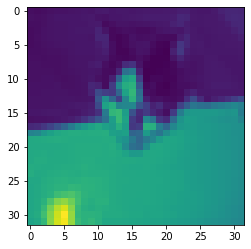

In [47]:
for img, lbl in val_batch_gen:
    break

i = 121

logits = mod(img[i:i+1].to(device))
print('pred and true objects:', val_ds.classes[np.argmax(logits.cpu().detach().numpy())], val_ds.classes[lbl[i]])

plt.imshow(img[i, 0].detach().cpu())